In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy
import seaborn as sns

In [31]:
def load_data(target='LDOBUSD'):
    data = pd.read_csv(f'../bookticker/{target}-bookTicker-2023-05.csv')
    data = data.rename(columns={
        'best_bid_price': 'bp', 
        'best_bid_qty': 'bv',
        'best_ask_price': 'ap', 
        'best_ask_qty': 'av',
        'event_time': 'time'  
        })
    data['trade_date'] = pd.to_datetime(data['time'] // 1000 // 60 // 60 // 24, unit='d')
    return data


In [33]:
def get_market_speed(data: pd.DataFrame, price_int: float):
    deltalist = np.linspace(price_int, price_int * 10, 10)
    deltadict = {}

    for delta in deltalist:
        price_interval = delta
        ask_limit_order_hit = data[('ap', 'max')].shift(-1) > (data[('ap', 'last')] + price_interval) 
        bid_limit_order_hit = data[('bp', 'min')].shift(-1) < (data[('bp', 'last')] - price_interval)
        limit_order_hit = (ask_limit_order_hit | bid_limit_order_hit).astype(int)
        deltas = pd.Series(limit_order_hit[limit_order_hit == 1].index).diff().apply(lambda x: x / 10)
        deltadict[delta] = deltas
    
    lambdas = pd.DataFrame([[key,1/deltadict[key].mean()] for key in deltadict.keys()],
                       columns=['delta','lambda_delta']).set_index('delta')
    
    def exp_fit(x,a,b):
        y = a*np.exp(-b*x)
        return y

    paramsB, cv = scipy.optimize.curve_fit(exp_fit, np.array(lambdas.index), np.array(lambdas['lambda_delta'].values))
    A, k = paramsB
    return A, k

In [34]:
def get_params(data: pd.DataFrame, price_int: float, time_step: int):
    data = data.copy(deep=True)    

    # 1. 按照time_step的频率把数据采样起来（相当于订单的更新的频率不能太高）
    data['ms-index'] = data['time'] // time_step    
    prices = data.groupby('ms-index').agg({
        'ap': ['last', 'max', 'min'],
        'bp': ['last', 'max', 'min']
        })
    
    # 2. 估计当前每条数据平均多少时间，用于估计交易时间
    min_index, max_index = prices.index[0], prices.index[prices.shape[0]-1]
    ave_time = time_step * (max_index - min_index) / prices.shape[0]

    # 2. 波动率
    prices['mid'] = (prices[('ap', 'last')] + prices[('bp', 'last')]) / 2
    sigma = np.log(prices['mid']).diff().std() * np.sqrt(24 * 60 * 60 * 1000 / ave_time)
    
    # 5. 市价单到达速率参数
    A, k = get_market_speed(prices, price_int)

    return sigma, A, k

def get_bid_spread(sigma, A, k, gamma, q):
    var1 = (1 / gamma) * np.log(1 + gamma / k)
    var2 = (2 * q + 1) / 2 * np.sqrt(sigma**2 * gamma / (2 * k * A) * (1 + gamma/k)**(1+k/gamma))
    return var1 + var2

def get_ask_spread(sigma, A, k, gamma, q):
    var1 = (1 / gamma) * np.log(1 + gamma / k)
    var2 = (2 * q - 1) / 2 * np.sqrt(sigma**2 * gamma / (2 * k * A) * (1 + gamma/k)**(1+k/gamma))
    return var1 - var2

In [42]:
def evaluation(data: pd.DataFrame, price_int: float, time_step: int, params: dict):
    """ 输入是一段历史成交的数据，来计算波动率
    """ 
    data = data.copy(deep=True)    
    date = data['trade_date'].iloc[0]
    
    # 1. 按照time_step的频率把数据合并起来
    data['ms-index'] = data['time'] // time_step    
    prices = data.groupby('ms-index').agg({
        'ap': ['last', 'max', 'min'],
        'bp': ['last', 'max', 'min']
        })
    
    prices['mid'] = (prices[('ap', 'last')] + prices[('bp', 'last')]) / 2
    
    # 4. 回测
    N = prices.shape[0]
    q    = np.array([params['q']] + [0] * (N-1))   # 补上上一轮回测的结果
    x    = np.array([params['x']] + [0] * (N-1), dtype=float)
    pnl  = np.array([params['pnl']] + [0] * (N-1), dtype=float)
    fees = np.array([params['fees']] + [0] * (N-1), dtype=float)
    ra = np.zeros(N)
    rb = np.zeros(N)

    sigma = params['sigma']
    A     = params['A']
    k     = params['k']
    gamma = params['gamma']
    fee_rate = params['fee_rate']

    for i in tqdm(range(N-1), desc=f'[evaluation {date}] '):
        
        ra[i] = prices['mid'].iloc[i] + get_ask_spread(sigma, A, k, gamma, q[i])
        rb[i] = prices['mid'].iloc[i] - get_bid_spread(sigma, A, k, gamma, q[i])

        # 这里限制了价格一定得是挂单方的价格，不会变成吃单
        ra[i] = max(prices[('ap', 'last')].iloc[i], np.floor(ra[i] * (1 / price_int)) * price_int)
        rb[i] = min(prices[('bp', 'last')].iloc[i], np.ceil(rb[i] * (1 / price_int)) * price_int)

        buy = 0
        sell = 0

        if prices[('ap', 'max')].iloc[i+1] > ra[i]:
            sell = 1
        
        if prices[('bp', 'min')].iloc[i+1] < rb[i]:
            buy = 1

        q[i+1] = q[i] + buy - sell
        x[i+1] = x[i] + sell*ra[i] - buy*rb[i]
        pnl[i+1]  = x[i+1] + q[i+1] * prices['mid'].iloc[i+1]
        fees[i+1] = fees[i] + sell*ra[i] * fee_rate + buy*rb[i] * fee_rate
    return pnl, x, q, fees

In [43]:
target = 'LDOBUSD'
fee_rate = 1.4e-4

trade_interval = 1000   
gamma = 0.01

price_int_dict = {'LDOBUSD': 0.0001, 'LTCBUSD': 0.01, 'BTCBUSD': 0.10, 'ETHBUSD': 0.01}
price_int      = price_int_dict[target]
data = load_data(target=target)
trade_dates = sorted(list(data['trade_date'].unique()))

In [64]:
last_q = 0
last_x = 0
last_pnl = 0
last_fees = 0

results = [[], [], [], []]
for i in range(len(trade_dates) - 1):
    valid_data = data[data['trade_date'] == trade_dates[i]]
    test_data  = data[data['trade_date'] == trade_dates[i]]

    sigma, A, k = get_params(valid_data, time_step=trade_interval, price_int=price_int)
    params = {'q': last_q, 'x': last_x, 'pnl': last_pnl, 'sigma': sigma, 'A': A, 'k': k, 'gamma': gamma, 'fees': last_fees, 'fee_rate': fee_rate}
    pnl, x, q, fees = evaluation(test_data, price_int=price_int, time_step=trade_interval, params=params)
    results[0].append(pnl)
    results[1].append(x)
    results[2].append(q)
    results[3].append(fees)

    last_q = q[-1]
    last_x = x[-1]
    last_pnl = pnl[-1]
    last_fees = fees[-1]

[evaluation 2023-05-30 00:00:00] : 100%|██████████| 64900/64900 [01:42<00:00, 632.71it/s]


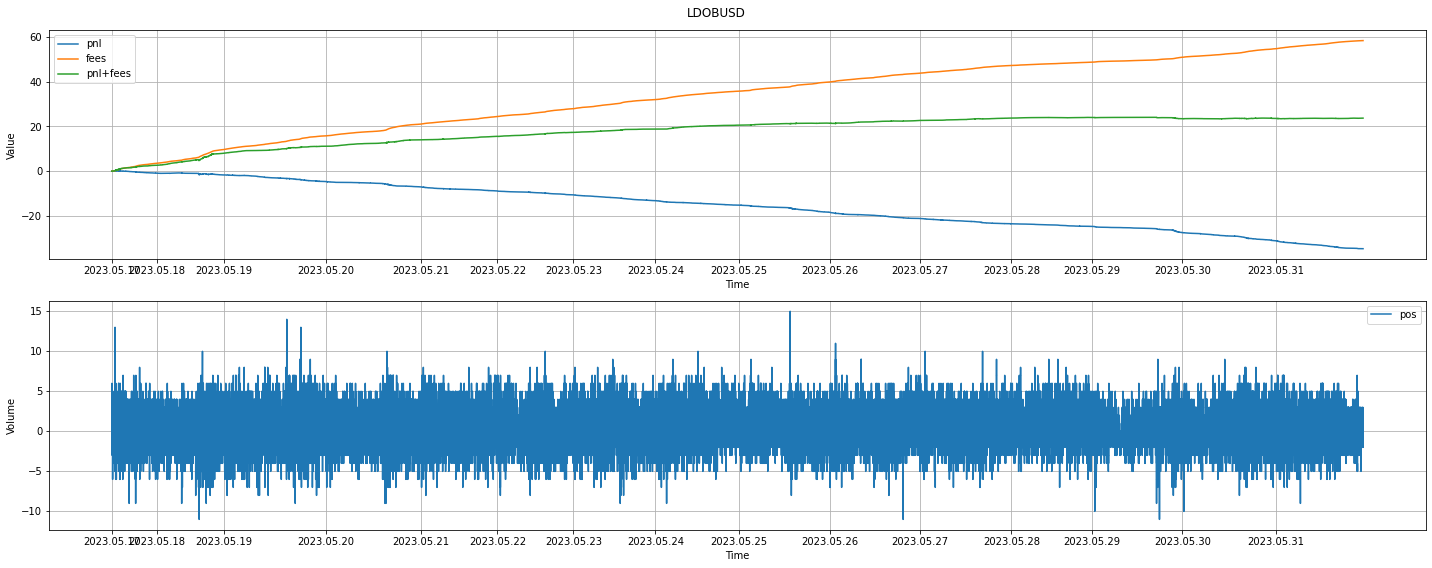

In [75]:
fig, axes = plt.subplots(2, 1, figsize=(20, 8))
ax1, ax2 = axes

dates_str = [pd.to_datetime(str(item)).strftime('%Y.%m.%d') for item in trade_dates][1:]    # 去掉第一个，因为第一天没有回测，只用来确定参数

xticks = [0]
for item in results[0][:-1]:
    xticks.append(xticks[-1] + item.shape[0])

ax1.plot(np.concatenate(results[0], axis=0), label='pnl')
ax1.plot(np.concatenate(results[3], axis=0), label='fees')
ax1.plot(np.concatenate(results[0], axis=0) + np.concatenate(results[3], axis=0) , label='pnl+fees')
ax1.grid()
ax1.legend()
ax1.set_xticks(xticks)
ax1.set_xticklabels(dates_str)
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')

ax2.plot(np.concatenate(results[2], axis=0), label='pos')
ax2.grid()
ax2.legend()
ax2.set_xticks(xticks)
ax2.set_xticklabels(dates_str)
ax2.set_xlabel('Time')
ax2.set_ylabel('Volume')
plt.suptitle(target)
fig.tight_layout()
plt.show()
